In [1]:
%matplotlib inline
# %matplotlib widget

In [2]:
import csv
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.facecolor':'white'})

### Helper Functions

In [10]:
# Given a dataset stats and results path, load in the DataFrame, merge and filter

def extract_dataset(stats_path, results_path, filter_by):
    if type(filter_by) == list:
        assert len(filter_by) == 1, "Can only extract 1 type of mapper"
        filter_by = filter_by[0]
    stats = []
    with open(stats_path) as f:
        for row in csv.DictReader(f):
            obj = {}
            for k,v in row.items():
                if k == 'mapper':
                    obj[k] = v
                elif k.startswith('id'):
                    pass
                elif v == '':
                    obj[k] = 0
                else:
                    obj[k] = float(v)
            obj['SBJ'] = row['id0'] # TODO! This only works for this type of data (fix!)
            stats.append(obj)
    print('len(stats): ', len(stats))


    MAX_INT = 100000
    results = []
    with open(results_path) as f:
        for row in csv.DictReader(f):
            obj = {}
            for k,v in row.items():
                if k == 'Mapper' or k == 'subject':
                    obj[k] = v
                else:
                    if v == 'Inf' or v == 'NaN':
                        obj[k] = MAX_INT
                    else:
                        obj[k] = float(v)
            results.append(obj)
    print('len(results): ', len(results))

    assert len(stats) == len(results)

    dfs = pd.DataFrame(data=stats)
    dfr = pd.DataFrame(data=results)

    df = pd.merge(dfr, dfs,  how='left', left_on=['Mapper','subject'], right_on = ['mapper','SBJ'])
    # df = dfr.join(dfs.set_index('Mapper'), on='Mapper')
    
    # Use filter_by
    df = df[df['Mapper'].str.startswith(filter_by)]

    param_cols = None
    if filter_by == 'BDLMapper' or filter_by == 'NeuMapper' or filter_by == 'EucNeuMapper':
        df['K'] = df.apply(lambda x: int(x['Mapper'].split('_')[1]), axis=1)
        df['R'] = df.apply(lambda x: int(x['Mapper'].split('_')[2]), axis=1)
        df['G'] = df.apply(lambda x: int(x['Mapper'].split('_')[3]), axis=1)
        param_cols = ['K', 'R', 'G']
    elif filter_by == 'CustomBDLMapper' or filter_by == 'CustomNeuMapper':
        df['preptype'] = df.apply(lambda x: x['Mapper'].split('_')[1], axis=1)
        df['dist'] = df.apply(lambda x: x['Mapper'].split('_')[2], axis=1)
        df['K'] = df.apply(lambda x: int(x['Mapper'].split('_')[3]), axis=1)
        df['R'] = df.apply(lambda x: int(x['Mapper'].split('_')[4]), axis=1)
        df['G'] = df.apply(lambda x: int(x['Mapper'].split('_')[5]), axis=1)
        df['linkbins'] = df.apply(lambda x: int(x['Mapper'].split('_')[6]), axis=1)
        param_cols = ['preptype', 'dist', 'K', 'R', 'G', 'linkbins']
    elif filter_by == 'CMDSMapperNoKNN':
        df['preptype'] = df.apply(lambda x: x['Mapper'].split('_')[1], axis=1)
        df['dist'] = df.apply(lambda x: x['Mapper'].split('_')[2], axis=1)
        df['R'] = df.apply(lambda x: int(x['Mapper'].split('_')[3]), axis=1)
        df['G'] = df.apply(lambda x: int(x['Mapper'].split('_')[4]), axis=1)
        df['linkbins'] = df.apply(lambda x: int(x['Mapper'].split('_')[5]), axis=1)
        param_cols = ['preptype', 'dist', 'R', 'G', 'linkbins']
    else:
        raise Exception('Mapper type not recognized')
        

    # fix CircleLoss and TransitionBetweeness
    max_values = {}
    for colname in ["CircleLoss", "TransitionBetweeness"]:
        if len(df[df[colname] < MAX_INT][colname]) == 0:
            raise Exception('There are no valid values for {}'.format(colname))
        new_max_loss = max(df[df[colname] < MAX_INT][colname]) * 1.5
        max_values[colname] = new_max_loss
        df[colname] = df.apply(lambda x: x[colname] if x[colname] != MAX_INT else new_max_loss, axis=1)

    main_cols = ['Mapper', 'SBJ'] + param_cols
    other_cols = [c for c in df.columns.tolist() if c not in main_cols and c != 'Mapper' and c != 'subject']
    df = df[main_cols + other_cols]
        
    return df, max_values

In [11]:
# Extract the subjects for each datset type and the combination that we should compute.
# for example: all SBJ2* would be SBJ20 and SBJ21
# For new datasets, this has to be changed

def get_all_parameters(df, dataset_name, silent=False):
    all_sbjs = df['SBJ'].unique().tolist()
    if not silent:
        print('Total {} subjects:'.format(len(all_sbjs)))
        for sbj in all_sbjs:
            print(sbj)


    sbjs_map = {}

    if dataset_name.startswith('ss_'):
        # This is for subsampled data
        for sbj in all_sbjs:
            sbjs_map[sbj] = [sbj]

        sbjs_map['SBJ2x'] = ['SBJ20', 'SBJ21']
        sbjs_map['SBJ4x'] = ['SBJ40', 'SBJ41', 'SBJ42', 'SBJ43']
        sbjs_map['SBJxx-50'] = [sbj for sbj in all_sbjs if sbj.endswith('-50.0')]
        sbjs_map['SBJxx-75'] = [sbj for sbj in all_sbjs if sbj.endswith('-75.0')]
        sbjs_map['SBJxx-83'] = [sbj for sbj in all_sbjs if sbj.endswith('-83.0')]
        sbjs_map['SBJxx-99'] = ['SBJ20', 'SBJ40', 'SBJ99']

    elif dataset_name.startswith('wnoise_'):
        # This is for wnoise data
        for sbj in all_sbjs:
            sbjs_map[sbj] = [sbj]

    elif dataset_name.startswith('hightr_'):
        # This is for subsampled data hightr
        for sbj in all_sbjs:
            sbjs_map[sbj] = [sbj]

        for i in [2,3,4]:
            sbjs_map['SBJe{}'.format(i)] = [s for s in all_sbjs if 'e{}v'.format(i) in s]

    if not silent:
        print('Extra combinations:')
        for sbjname, sbjs_list in sbjs_map.items():
            if len(sbjs_list) > 1:
                print(sbjname, ':', sbjs_list)
            
    return all_sbjs, sbjs_map

In [5]:
from matplotlib.colors import LogNorm, Normalize

def _handle_list_cols(df, col):
    if type(col) == list:
        newcol = '_'.join(col)
        df[newcol] = df.apply(lambda x: '_'.join([str(x[c]) for c in col]), axis=1)
        col = newcol
    return df, col
    

# For a DataFrame, compute a big figure with multiple subplots
# Each row would be a different metric (some metrics are in log scale `log_metrics`)
# Each column is a different value of the fixedV column (usually `R`)
# For each subplot, x-axis is colV column (usually `G`) and y-axis is indexV column (usually `K`)
# The `sbj_group_name` is the name of the group of subjects
def plot_results(df, sbj_group_name, sbj_group, fixedV, indexV, colV, target_metrics, log_metrics, resdir):
    df, fixedV = _handle_list_cols(df, fixedV)
    df, indexV = _handle_list_cols(df, indexV)
    df, colV = _handle_list_cols(df, colV)
    
    df_filter = df['SBJ'] == sbj_group[0]
    for idx in range(1,len(sbj_group)):
        df_filter = df_filter | (df['SBJ'] == sbj_group[idx])
    
    newtypes = {}
    allcols = []
    for col in [fixedV, indexV, colV]:
        col = col if type(col) == list else [col]
        allcols.extend(col)
        for c in col:
            if c in ['K', 'G', 'R', 'linkbins']:
                newtypes[c] = 'int'
                
    # Filter and group by subject/subjects
    dff = df[df_filter]
    dff = dff.groupby(['Mapper'] + allcols).mean()
    dff = dff.reset_index().astype(newtypes)
    # Deprecated below
    # Don't recompute CircleLossRev as next line, average over the CircleLossRev!
    # dff['CircleLossRev'] = dff.apply(lambda x: 1.0 / x['CircleLoss'] if x['CircleLoss'] > 0 else 100, axis=1)

    fixed_vals = sorted(list(set(df[fixedV].to_list())))
    f, axr = plt.subplots(len(target_metrics), len(fixed_vals), figsize=(4 * len(fixed_vals), 4 * len(target_metrics)))

    for axc, target in zip(axr, target_metrics):
        vmin, vmax = min(df[target]), max(df[target]) # get vmin and vmax based on all results not only for the sbj group
        for col_idx,(K,ax) in enumerate(zip(fixed_vals,axc)):
            df_p = dff[dff[fixedV] == K].pivot(index=indexV, columns=colV, values=target)
            
            last_col = col_idx == len(axc) - 1
            if target in log_metrics:
                ax = sns.heatmap(df_p, norm=LogNorm(vmin=vmin, vmax=vmax), ax=ax, cbar=not last_col)
            else:
                ax = sns.heatmap(df_p, vmin=vmin, vmax=vmax, ax=ax, cbar=not last_col)
            ax.set_title('{} == {}'.format(fixedV, K))

            if last_col:
                ax1 = ax.twinx()
                ax1.set_ylabel(target)
                ax1.set_yticks([])

    plt.tight_layout()
    plt.savefig(os.path.join(resdir,'plot_results_{}.png'.format(sbj_group_name)))
    plt.close()
    
    
# Similar to `plot_results`, this function has a map of target_metrics to an interval.
# If the picked metric inside the interval, then the value is 1, otherwise its 0
# This figure also has a row of TOTAL where all metrics are combined to yield the combination of "AND" on all metrics
def plot_limits(df, sbj_group_name, sbj_group, fixedV, indexV, colV, target_metrics, resdir):
    df, fixedV = _handle_list_cols(df, fixedV)
    df, indexV = _handle_list_cols(df, indexV)
    df, colV = _handle_list_cols(df, colV)

    newtypes = {}
    allcols = []
    for col in [fixedV, indexV, colV]:
        col = col if type(col) == list else [col]
        allcols.extend(col)
        for c in col:
            if c in ['K', 'G', 'R', 'linkbins']:
                newtypes[c] = 'int'
    
    df_filter = df['SBJ'] == sbj_group[0]
    for idx in range(1,len(sbj_group)):
        df_filter = df_filter | (df['SBJ'] == sbj_group[idx])
    
    dff = df[df_filter]
    dff = dff.groupby(['Mapper'] + allcols).mean()
    dff = dff.reset_index().astype(newtypes)

    fixed_vals = sorted(list(set(df[fixedV].to_list())))
    f, axr = plt.subplots(len(target_metrics)+1, len(fixed_vals), figsize=(4 * len(fixed_vals), 4 * len(target_metrics) + 4))
    
    for axc, (target, lims) in zip(axr, target_metrics.items()):
        vmin, vmax = min(df[target]), max(df[target]) # get vmin and vmax based on all results not only for the sbj group
        for col_idx,(K,ax) in enumerate(zip(fixed_vals,axc)):
            df_p = dff[dff[fixedV] == K].pivot(index=indexV, columns=colV, values=target)
            df_wl = (df_p >= lims[0]) & (df_p <= lims[1]) # within limits
            
            last_col = col_idx == len(axc)-1
            ax = sns.heatmap(df_wl, vmin=0.0, vmax=1.0, ax=ax, cbar=not last_col)
            ax.set_title('{} == {}'.format(fixedV, K))
            if last_col:
                ax1 = ax.twinx()
                ax1.set_ylabel(target)
                ax1.set_yticks([])
                
    
    # plot the combined plot
    axc = axr[len(target_metrics)]

    for col_idx,(K,ax) in enumerate(zip(fixed_vals,axc)):
        comb_isset = False
        df_comb = None
        for target, lims in target_metrics.items():
            df_p = dff[dff[fixedV] == K].pivot(index=indexV, columns=colV, values=target)
            df_wl = (df_p >= lims[0]) & (df_p <= lims[1]) # within limits
            if not comb_isset:
                df_comb = df_wl
                comb_isset = True
            else:
                df_comb = df_comb & df_wl

        last_col = col_idx == len(axc)-1
        ax = sns.heatmap(df_comb, vmin=0.0, vmax=1.0, ax=ax, cbar=not last_col)
        ax.set_title('{} == {}'.format(fixedV, K))

        if last_col:
            ax1 = ax.twinx()
            ax1.set_ylabel('TOTAL')
            ax1.set_yticks([])


    plt.tight_layout()
    plt.savefig(os.path.join(resdir,'plot_limits_{}.png'.format(sbj_group_name)))
    plt.close()


# Start analysis

In [12]:
import os
import csv
from tqdm import tqdm

sns.set(rc={'figure.facecolor':'white'})

DATASETS = {
    'ss_w3cv1': '/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv1.json/',
    'ss_w3cv2': '/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv2.json/',
    'ss_w3cv3': '/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv3.json/',
    'ss_w3cv4': '/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv4.json/',
    'ss_w3cv4euc': '/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv4_euc.json/',
    'ss_w3cv5': '/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv5fixed.json/',
    'ss_w3cv6': '/Users/dh/workspace/BDL/demapper/results/w3c_ss/analysis/mappers_w3cv6fixed.json/',
    'wnoise_w3cv1': '/Users/dh/workspace/BDL/demapper/results/w3c_wnoise/analysis/mappers_w3cv1.json/',
    'wnoise_w3cv2': '/Users/dh/workspace/BDL/demapper/results/w3c_wnoise/analysis/mappers_w3cv2.json/',
    'wnoise_w3cv4': '/Users/dh/workspace/BDL/demapper/results/w3c_wnoise/analysis/mappers_w3cv4.json/',
    'wnoise_w3cv4euc': '/Users/dh/workspace/BDL/demapper/results/w3c_wnoise/analysis/mappers_w3cv4_euc.json/',
    'wnoise_w3cv5': '/Users/dh/workspace/BDL/demapper/results/w3c_wnoise/analysis/mappers_w3cv5dist.json/',
    'wnoise_w3cv6': '/Users/dh/workspace/BDL/demapper/results/w3c_wnoise/analysis/mappers_w3cv6dist.json/',
    'hightr_w3cv1': '/Users/dh/workspace/BDL/demapper/results/w3c_hightr/analysis/mappers_w3cv1.json/',
    'hightr_w3cv2': '/Users/dh/workspace/BDL/demapper/results/w3c_hightr/analysis/mappers_w3cv2.json/',
    'hightr_w3cv3': '/Users/dh/workspace/BDL/demapper/results/w3c_hightr/analysis/mappers_w3cv3.json/',
    'hightr_w3cv4': '/Users/dh/workspace/BDL/demapper/results/w3c_hightr/analysis/mappers_w3cv4.json/',
    'hightr_w3cv4euc': '/Users/dh/workspace/BDL/demapper/results/w3c_hightr/analysis/mappers_w3cv4_euc.json/',
    'hightr_w3cv5': '/Users/dh/workspace/BDL/demapper/results/w3c_hightr/analysis/mappers_w3cv5dist.json/',
    'hightr_w3cv6': '/Users/dh/workspace/BDL/demapper/results/w3c_hightr/analysis/mappers_w3cv6dist.json/',
}

FILTERS = {}
for k in DATASETS.keys():
    if k.endswith('w3cv1') or k.endswith('w3cv3'):
        FILTERS[k] = ['BDLMapper']
    elif k.endswith('w3cv2') or k.endswith('w3cv4'):
        FILTERS[k] = ['NeuMapper']
    elif k.endswith('w3cv4euc'):
        FILTERS[k] = ['EucNeuMapper']
    if k.endswith('w3cv5'):
        FILTERS[k] = ['CustomBDLMapper', 'CMDSMapperNoKNN']
    if k.endswith('w3cv6'):
        FILTERS[k] = ['CustomNeuMapper']

def get_plot_columns(mapper_name):
    if mapper_name == 'NeuMapper' or mapper_name == 'BDLMapper' or mapper_name == 'EucNeuMapper':
        fixedV, indexV, colV = 'R', 'K', 'G' # Most informative
    elif mapper_name == 'CustomBDLMapper' or mapper_name == 'CustomNeuMapper':
        fixedV, indexV, colV = 'dist', ['G', 'K'], ['preptype', 'R', 'linkbins']
    elif mapper_name == 'CMDSMapperNoKNN':
        fixedV, indexV, colV = 'dist', ['G', 'linkbins'], ['preptype', 'R']
    else:
        raise Exception('Cannot find plot vars (for columns) for Mapper {}'.format(mapper_name))
    return fixedV, indexV, colV
        
circle_loss_threshold = 10.0

In [33]:
# PICKED_DATASET = 'ss_w3cv3'
PICKED_DATASET = 'ss_w3cv4euc'


datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by)

resdir = datadir
if len(FILTERS[PICKED_DATASET]) > 1:
    resdir = os.path.join(datadir, filter_by)
    os.makedirs(resdir, exist_ok=True)


all_sbjs, sbjs_map = get_all_parameters(df, PICKED_DATASET)

print(max_values)
df.sample(5)

len(stats):  9800
len(results):  9800
Total 14 subjects:
SBJ20
SBJ20-50.0
SBJ20-75.0
SBJ20-83.0
SBJ21
SBJ40
SBJ40-50.0
SBJ40-75.0
SBJ40-83.0
SBJ41
SBJ99
SBJ99-50.0
SBJ99-75.0
SBJ99-83.0
Extra combinations:
SBJ2x : ['SBJ20', 'SBJ21']
SBJ4x : ['SBJ40', 'SBJ41', 'SBJ42', 'SBJ43']
SBJxx-50 : ['SBJ20-50.0', 'SBJ40-50.0', 'SBJ99-50.0']
SBJxx-75 : ['SBJ20-75.0', 'SBJ40-75.0', 'SBJ99-75.0']
SBJxx-83 : ['SBJ20-83.0', 'SBJ40-83.0', 'SBJ99-83.0']
SBJxx-99 : ['SBJ20', 'SBJ40', 'SBJ99']
{'CircleLoss': 74.97461832061065, 'TransitionBetweeness': 16.5}


,Mapper,SBJ,K,R,G,CircleLoss,TransitionBetweeness,mapper,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy
7849,EucNeuMapper_70_100_25,SBJ41,70,100,25,74.974618,16.5,EucNeuMapper_70_100_25,0.229814,0.383323,0.465839,8.0,2.80271,0.119103,11.6833,4.59381
743,EucNeuMapper_100_500_40,SBJ20-50.0,100,500,40,74.974618,16.5,EucNeuMapper_100_500_40,0.332867,0.346939,0.268531,24.0,2.86130,0.401179,63.7143,6.72529
4353,EucNeuMapper_40_300_25,SBJ99-83.0,40,300,25,74.974618,16.5,EucNeuMapper_40_300_25,0.328421,0.383948,0.138947,16.0,2.81843,0.239545,11.3803,4.68543
3710,EucNeuMapper_30_500_55,SBJ20,30,500,55,0.545437,1.0,EucNeuMapper_30_500_55,0.996667,0.998800,0.693333,18.0,3.79157,0.413729,985.5450,9.93630
7168,EucNeuMapper_60_25_35,SBJ20,60,25,35,0.128571,0.0,EucNeuMapper_60_25_35,1.000000,1.000000,0.896552,3.0,1.81035,0.364664,64.3017,4.51622


In [34]:

target_metrics = ['CircleLossRev', 'TransitionBetweenessRev', 'coverage_nodes', 'hrfdur_stat', 'distances_entropy']
log_metrics = ['CircleLossRev', 'TransitionBetweenessRev']

df['CircleLossRev'] = df.apply(lambda x: 1.0 / x['CircleLoss'] if x['CircleLoss'] > 0 else 100, axis=1)
df['TransitionBetweenessRev'] = df.apply(lambda x: 1.0 / (x['TransitionBetweeness'] + 1), axis=1)

plot_results(df, 'SBJ99_KRG', ['SBJ99'], 'K', 'R', 'G', target_metrics, log_metrics, resdir=resdir)


In [35]:
# Plot limits

target_metrics = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99],
    'coverage_nodes': [0.7, 1.0],
#     'hrfdur_stat': [0.15, 1.0],
    'distances_entropy': [2.0, 10000.0]
}

plot_limits(df, 'SBJ99_KRG', ['SBJ99'], 'K', 'R', 'G', target_metrics, resdir=resdir)

In [36]:
fullname = {
    'R': 'Resolution',
    'G': 'Gain'
}


target_metrics = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99],
    'coverage_nodes': [0.7, 1.0],
#     'hrfdur_stat': [0.15, 1.0],
    'distances_entropy': [2.0, 10000.0]
}

def plot_merger(df, sbj_group_name, sbj_group, fixedV, fixedVals, indexV, colV, target_metrics, resdir):
    df, fixedV = _handle_list_cols(df, fixedV)
    df, indexV = _handle_list_cols(df, indexV)
    df, colV = _handle_list_cols(df, colV)

    newtypes = {}
    allcols = []
    for col in [fixedV, indexV, colV]:
        col = col if type(col) == list else [col]
        allcols.extend(col)
        for c in col:
            if c in ['K', 'G', 'R', 'linkbins']:
                newtypes[c] = 'int'

    df_filter = df['SBJ'] == sbj_group[0]
    for idx in range(1,len(sbj_group)):
        df_filter = df_filter | (df['SBJ'] == sbj_group[idx])

    dff = df[df_filter]
    dff = dff.groupby(['Mapper'] + allcols).mean()
    dff = dff.reset_index().astype(newtypes)

    fixed_vals = sorted(list(set(df[fixedV].to_list())))
    # Create combs
    combs = []
    for col_idx,K in enumerate(fixed_vals):
        comb_isset = False
        df_comb = None
        for target, lims in target_metrics.items():
            df_p = dff[dff[fixedV] == K].pivot(index=indexV, columns=colV, values=target)
            df_wl = (df_p >= lims[0]) & (df_p <= lims[1]) # within limits
            if not comb_isset:
                df_comb = df_wl
                comb_isset = True
            else:
                df_comb = df_comb & df_wl

        combs.append(df_comb)
        
    iV = combs[0].index.to_list()
    cV = combs[0].columns.to_list()
    added = np.zeros_like(combs[0].to_numpy())

    cnt = 0
    for k,fV in enumerate(fixed_vals):
        if fV in fixedVals:
            M = combs[k].to_numpy() * 1
#             print(fV, added.shape, M.shape)
            added = added + M
            cnt += 1

    ax = sns.heatmap(np.flip(added / cnt, 0), xticklabels=cV, yticklabels=iV[::-1], vmax=1.0)
    ax.set_ylabel(fullname[indexV])
    ax.set_xlabel(fullname[colV])
    plt.tight_layout()
    plt.savefig(os.path.join(resdir,'plot_merger{}{}_{}.png'.format(indexV, colV, sbj_group_name)), dpi=150)
    plt.close()


In [37]:

for sbj_group_name, sbj_group in tqdm(sbjs_map.items()):
    fixedV = 'K'
    fixedVals = [10, 20, 30, 40, 50, 60, 70] # for NeuMapper and BDLMapper
    plot_merger(df, sbj_group_name, sbj_group, fixedV, fixedVals, 'R', 'G', target_metrics, resdir=resdir)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.62it/s]


,Mapper,SBJ,K,R,G,CircleLoss,TransitionBetweeness,mapper,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy,CircleLossRev,TransitionBetweenessRev
0,NeuMapper_100_100_25,SBJ20,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.553957,0.584883,0.460432,20.0,3.80631,0.022352,28.5225,5.93724,0.016574,0.181818
1,NeuMapper_100_100_25,SBJ20-50.0,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.264706,0.403361,0.264706,10.0,2.69076,0.084638,16.2809,5.24022,0.016574,0.181818
2,NeuMapper_100_100_25,SBJ20-75.0,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.409091,0.440000,0.393939,16.0,3.55220,0.075818,24.9488,5.78353,0.016574,0.181818
3,NeuMapper_100_100_25,SBJ20-83.0,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.458015,0.499638,0.404580,17.0,3.48939,0.156666,34.5293,6.26467,0.016574,0.181818
4,NeuMapper_100_100_25,SBJ21,100,100,25,60.334951,4.5,NeuMapper_100_100_25,0.400000,0.538692,0.453846,11.0,3.11294,0.063801,32.7115,6.17703,0.016574,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11755,NeuMapper_80_50_75,SBJ41,80,50,75,0.444444,4.5,NeuMapper_80_50_75,1.000000,1.000000,1.000000,3.0,1.43237,0.096786,374.9180,4.92024,2.250000,0.181818
11756,NeuMapper_80_50_75,SBJ99,80,50,75,0.092437,4.5,NeuMapper_80_50_75,1.000000,1.000000,0.962264,3.0,1.57309,0.232076,298.6230,3.93364,10.818182,0.181818
11757,NeuMapper_80_50_75,SBJ99-50.0,80,50,75,0.133333,0.0,NeuMapper_80_50_75,1.000000,1.000000,0.903846,4.0,1.89020,0.064162,230.0550,3.91960,7.500000,1.000000
11758,NeuMapper_80_50_75,SBJ99-75.0,80,50,75,0.076923,0.0,NeuMapper_80_50_75,1.000000,1.000000,0.888889,4.0,1.76498,0.138503,240.1440,4.30888,13.000000,1.000000


In [31]:

for sbj_group_name, sbj_group in tqdm(sbjs_map.items()):
    fixedV = 'K'
    fixedVals = [10, 20, 30, 40, 50, 60, 70]
    dff = df[df['R'] <= 500]
    plot_merger(dff, sbj_group_name, sbj_group, fixedV, fixedVals, 'G', 'R', target_metrics, resdir=resdir)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.37it/s]


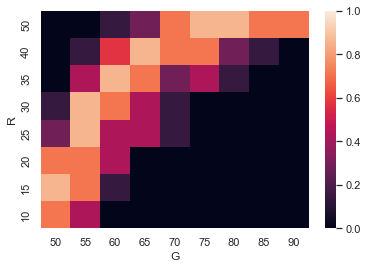

In [79]:
fixedV = 'K'
fixedVals = [10, 20, 30, 40, 50, 60, 70]
plot_merger(df, 'SBJ99_KRG', ['SBJ41'], fixedV, fixedVals, 'R', 'G', target_metrics, resdir=resdir)

<AxesSubplot:>

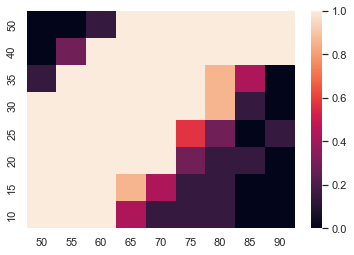

In [45]:
sns.heatmap(np.flip(added / cnt, 1), xticklabels=G, yticklabels=R[::-1])

array([[ True,  True,  True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False, False],
       [False, False, False,  True,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True]])